<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


<h1>Linear regression 1D: Training Two Parameter Stochastic Gradient Descent (SGD)</h1>


<h2>Objective</h2><ul><li> How to use SGD(Stochastic Gradient Descent) to train the model.</li></ul> 


<h2>Table of Contents</h2>
<p>In this Lab, you will practice training a model by using Stochastic Gradient descent.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Create the Model and Cost Function (Total Loss)</a></li>
    <li><a href="#BGD">Train the Model:Batch Gradient Descent</a></li>
    <li><a href="#SGD">Train the Model:Stochastic gradient descent</a></li>
    <li><a href="#SGD_Loader">Train the Model:Stochastic gradient descent with Data Loader</a></li>
</ul>
<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:  


In [1]:
# These are the libraries we are going to use in the lab.

import torch
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits import mplot3d

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with PyTorch.


In [2]:
# The class for plot the diagram

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1,cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
    
    # Setter
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1
        self.W.append(W)
        self.B.append(B)
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label = "training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data</h2>


Set random seed: 


In [3]:
# Set random seed

torch.manual_seed(1)

Generate values from <i>-3</i> to <i>3</i> that create a line with a slope of <i>1</i> and a bias of <i>-1</i>. This is the line that you need to estimate. Add some noise to the data:


In [4]:
# Setup the actual data and simulated data

X = torch.arange(-3, 3, 0.1).view(-1, 1)
f = 1 * X - 1
Y = f + 0.1 * torch.randn(X.size())

Plot the results:


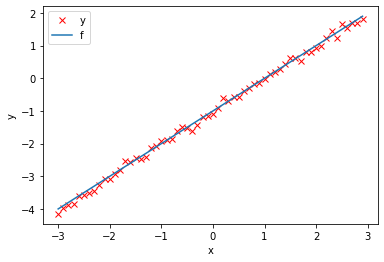

In [5]:
# Plot out the data dots and line

plt.plot(X.numpy(), Y.numpy(), 'rx', label = 'y')
plt.plot(X.numpy(), f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<!--Empty Space for separating topics-->


<h2 id="Model_Cost">Create the Model and Cost Function (Total Loss)</h2>


Define the <code>forward</code> function:


In [6]:
# Define the forward function

def forward(x):
    return w * x + b

Define the cost or criterion function (MSE): 


In [7]:
# Define the MSE Loss function

def criterion(yhat, y):
    return torch.mean((yhat - y) ** 2)

Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


<Figure size 432x288 with 0 Axes>

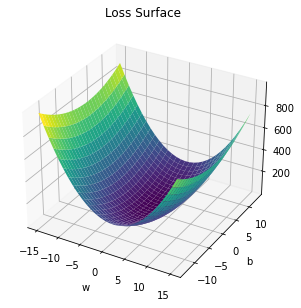

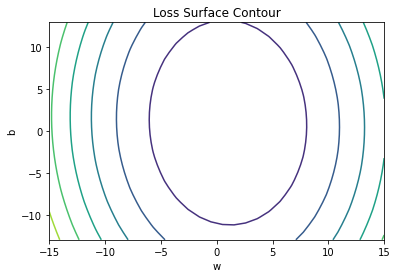

In [8]:
# Create plot_error_surfaces for viewing the data

get_surface = plot_error_surfaces(15, 13, X, Y, 30)

<!--Empty Space for separating topics-->


<h2 id="BGD">Train the Model: Batch Gradient Descent</h2>


Create model parameters <code>w</code>, <code>b</code> by setting the argument <code>requires_grad</code> to True because the system must learn it.


In [9]:
# Define the parameters w, b for y = wx + b

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

Set the learning rate to  0.1 and create an empty list <code>LOSS</code> for storing the loss for each iteration.


In [10]:
# Define learning rate and create an empty list for containing the loss for each iteration.

lr = 0.1
LOSS_BGD = []

Define <code>train_model</code> function for train the model.


In [11]:
# The function for training the model

def train_model(iter):
    
    # Loop
    for epoch in range(iter):
        
        # make a prediction
        Yhat = forward(X)
        
        # calculate the loss 
        loss = criterion(Yhat, Y)

        # Section for plotting
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        get_surface.plot_ps()
            
        # store the loss in the list LOSS_BGD
        LOSS_BGD.append(loss)
        
        # backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        
        # update parameters slope and bias
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        
        # zero the gradients before running the backward pass
        w.grad.data.zero_()
        b.grad.data.zero_()

Run 10 epochs of batch gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


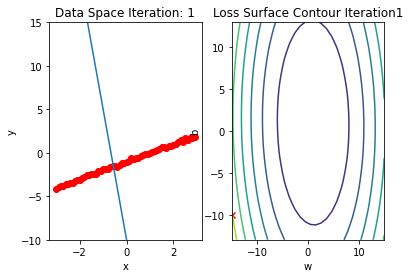

/home/francisco/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


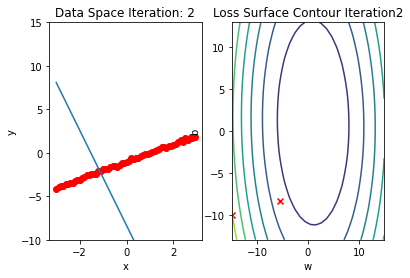

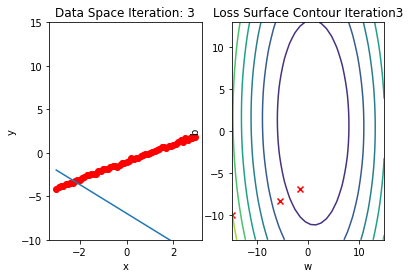

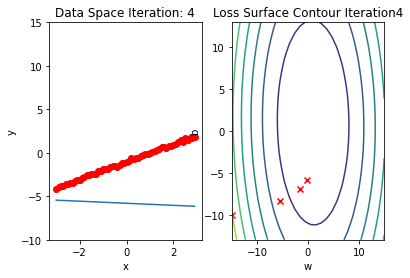

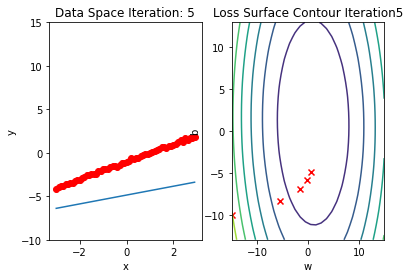

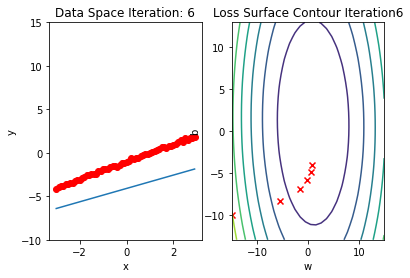

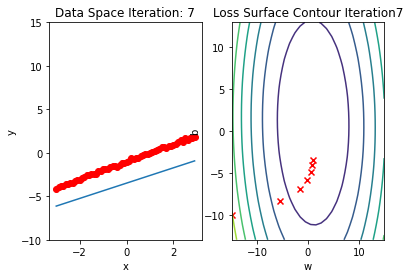

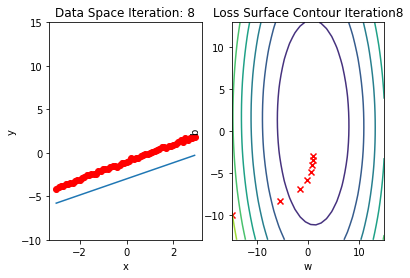

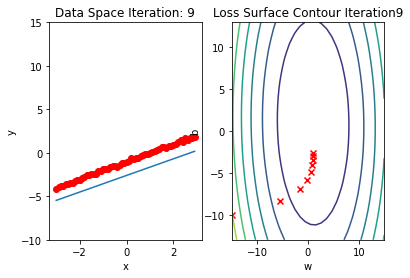

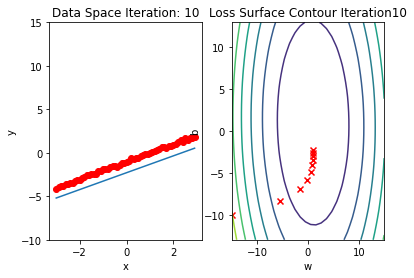

In [12]:
# Train the model with 10 iterations

train_model(10)

<!--Empty Space for separating topics-->


<h2 id="SGD">Train the Model: Stochastic Gradient Descent</h2>


Create a <code>plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


In [13]:
# Create plot_error_surfaces for viewing the data

get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

Define <code>train_model_SGD</code> function for training the model.


In [14]:
# The function for training the model

LOSS_SGD = []
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

def train_model_SGD(iter):
    
    # Loop
    for epoch in range(iter):
        
        # SGD is an approximation of out true total loss/cost, in this line of code we calculate our true loss/cost and store it
        Yhat = forward(X)

        # store the loss 
        LOSS_SGD.append(criterion(Yhat, Y).tolist())
        
        for x, y in zip(X, Y):
            
            # make a pridiction
            yhat = forward(x)
        
            # calculate the loss 
            loss = criterion(yhat, y)

            # Section for plotting
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        
            # backward pass: compute gradient of the loss with respect to all the learnable parameters
            loss.backward()
        
            # update parameters slope and bias
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data

            # zero the gradients before running the backward pass
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        #plot surface and data space after each epoch    
        get_surface.plot_ps()

Run 10 epochs of stochastic gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


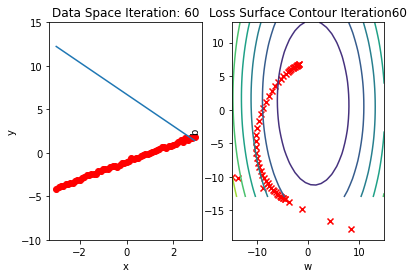

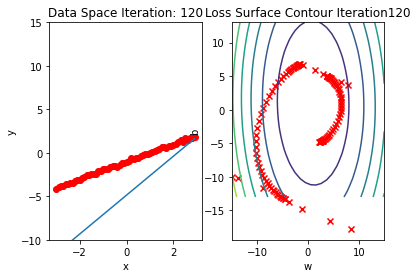

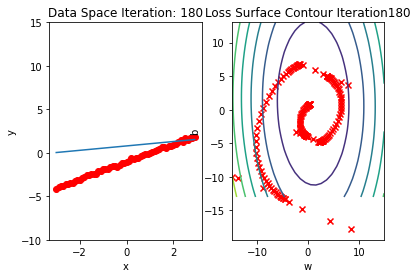

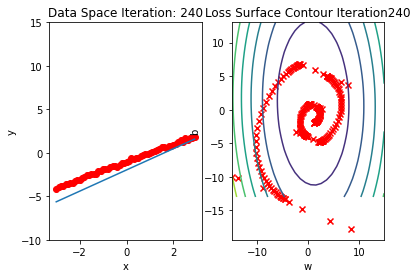

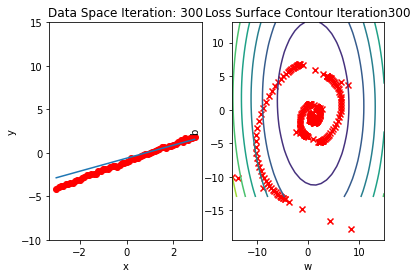

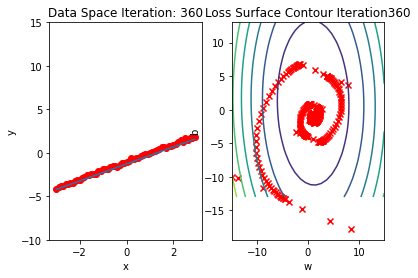

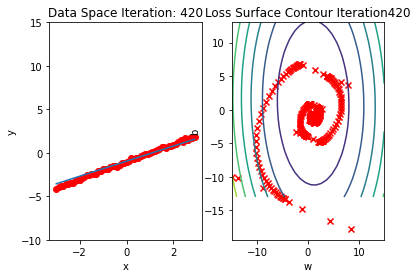

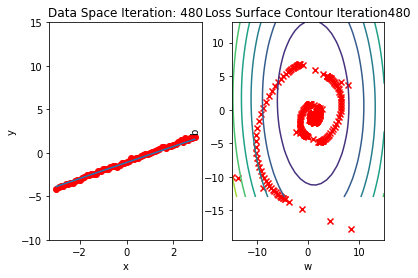

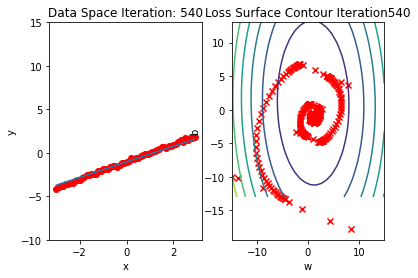

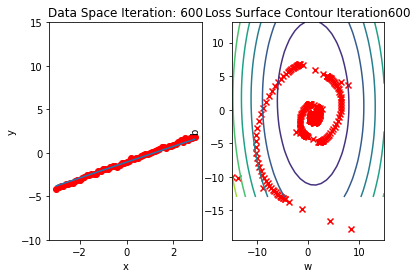

In [15]:
# Train the model with 10 iterations

train_model_SGD(10)

Compare the loss of both batch gradient descent as SGD.


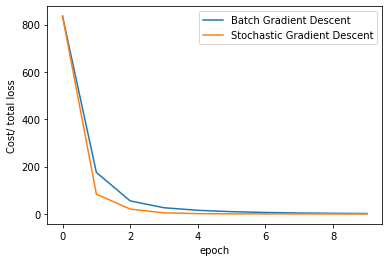

In [16]:
# Plot out the LOSS_BGD and LOSS_SGD

plt.plot(LOSS_BGD,label = "Batch Gradient Descent")
plt.plot(LOSS_SGD,label = "Stochastic Gradient Descent")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

<!--Empty Space for separating topics-->


<h2 id="SGD_Loader">SGD with Dataset DataLoader</h2>


Import the module for building a dataset class: 


In [17]:
# Import the library for DataLoader

from torch.utils.data import Dataset, DataLoader

Create a dataset class:


In [18]:
# Dataset Class

class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        self.y = 1 * self.x - 1
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):    
        return self.x[index], self.y[index]
    
    # Return the length
    def __len__(self):
        return self.len

Create a dataset object and check the length of the dataset.


In [19]:
# Create the dataset and check the length

dataset = Data()
print("The length of dataset: ", len(dataset))

The length of dataset:  60


Obtain the first training point:  


In [20]:
# Print the first point

x, y = dataset[0]
print("(", x, ", ", y, ")")

( tensor([-3.]) ,  tensor([-4.]) )


Similarly, obtain the first three training points:  


In [21]:
# Print the first 3 point

x, y = dataset[0:3]
print("The first 3 x: ", x)
print("The first 3 y: ", y)

The first 3 x:  tensor([[-3.0000],
        [-2.9000],
        [-2.8000]])
The first 3 y:  tensor([[-4.0000],
        [-3.9000],
        [-3.8000]])


Create a <code>plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


In [22]:
# Create plot_error_surfaces for viewing the data

get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

Create a <code>DataLoader</code> object by using the constructor: 


In [23]:
# Create DataLoader

trainloader = DataLoader(dataset = dataset, batch_size = 1)

Define <code>train_model_DataLoader</code> function for training the model.


In [24]:
# The function for training the model

w = torch.tensor(-15.0,requires_grad=True)
b = torch.tensor(-10.0,requires_grad=True)
LOSS_Loader = []

def train_model_DataLoader(epochs):
    
    # Loop
    for epoch in range(epochs):
        
        # SGD is an approximation of out true total loss/cost, in this line of code we calculate our true loss/cost and store it
        Yhat = forward(X)
        
        # store the loss 
        LOSS_Loader.append(criterion(Yhat, Y).tolist())
        
        for x, y in trainloader:
            
            # make a prediction
            yhat = forward(x)
            
            # calculate the loss
            loss = criterion(yhat, y)
            
            # Section for plotting
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            
            # Backward pass: compute gradient of the loss with respect to all the learnable parameters
            loss.backward()
            
            # Updata parameters slope
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr* b.grad.data
            
            # Clear gradients 
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        #plot surface and data space after each epoch    
        get_surface.plot_ps()

Run 10 epochs of stochastic gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


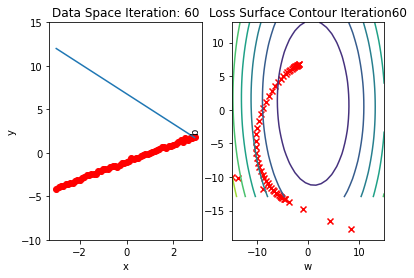

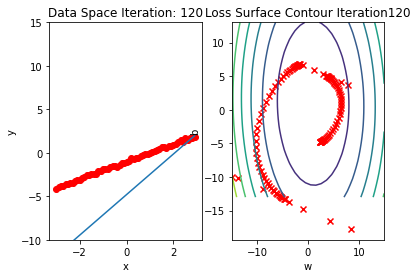

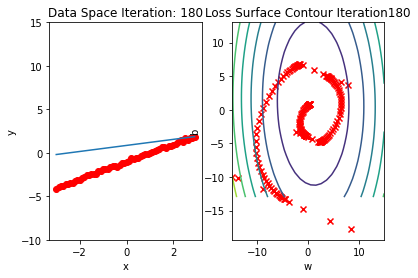

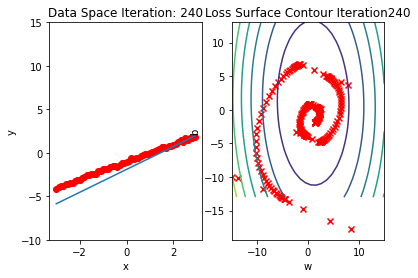

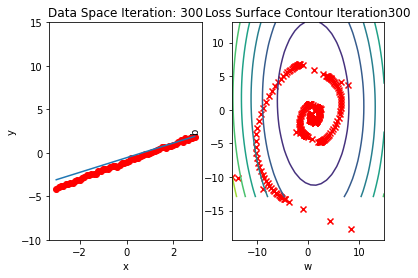

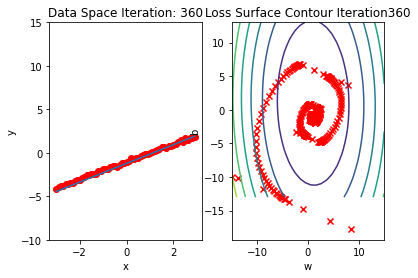

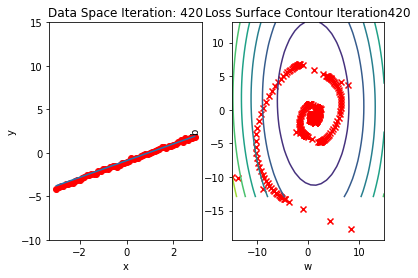

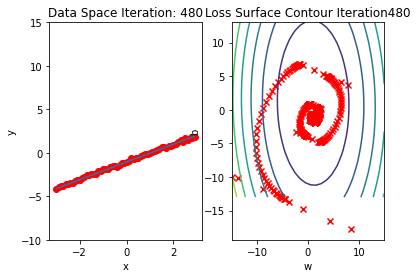

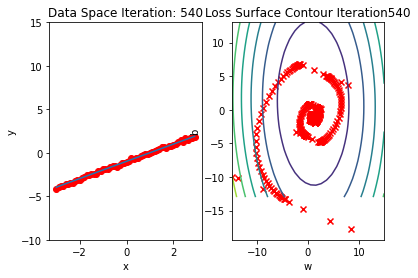

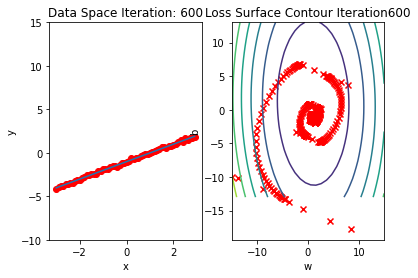

In [25]:
# Run 10 iterations

train_model_DataLoader(10)

Compare the loss of both batch gradient decent as SGD. Note that SGD converges to a minimum faster, that is, it decreases faster. 


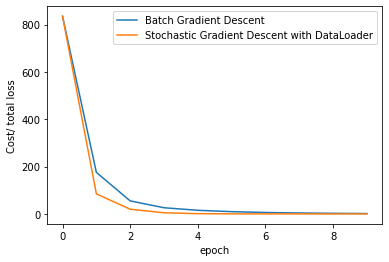

In [26]:
# Plot the LOSS_BGD and LOSS_Loader

plt.plot(LOSS_BGD,label="Batch Gradient Descent")
plt.plot(LOSS_Loader,label="Stochastic Gradient Descent with DataLoader")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

<h3>Practice</h3>


For practice, try to use SGD with DataLoader to train model with 10 iterations. Store the total loss in <code>LOSS</code>. We are going to use it in the next question.


<Figure size 432x288 with 0 Axes>

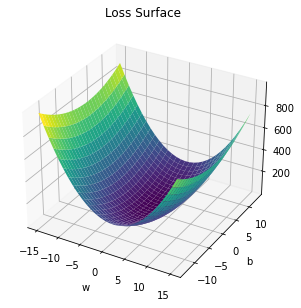

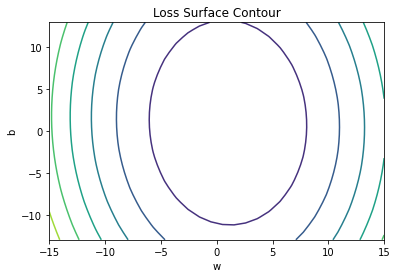

In [32]:
get_surface_2 = plot_error_surfaces(15, 13, X, Y, 30)

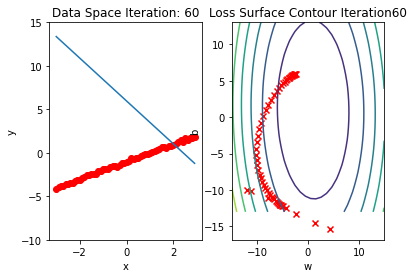

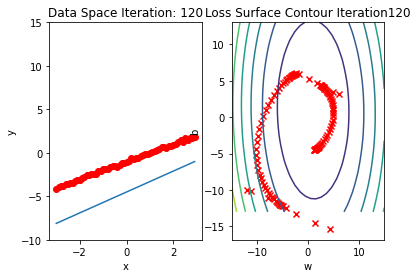

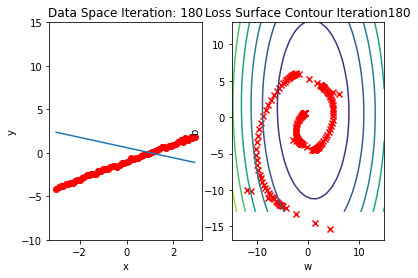

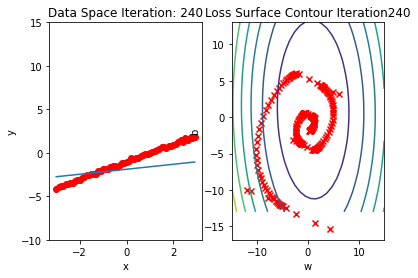

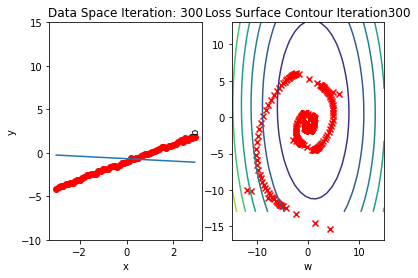

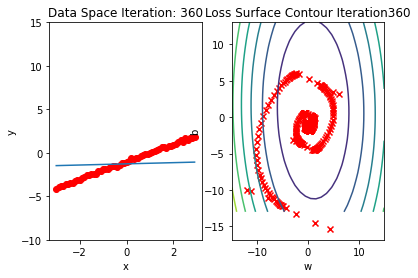

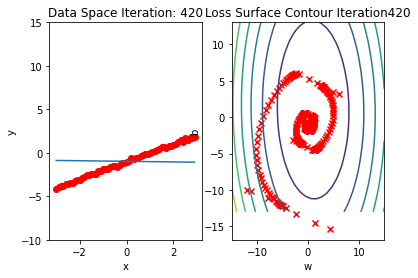

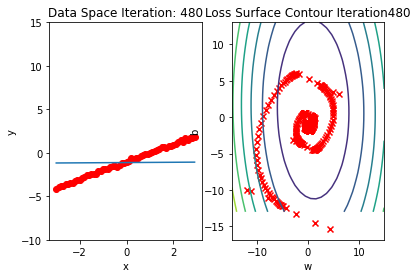

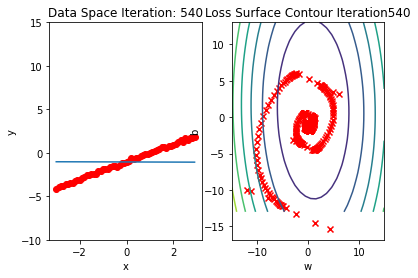

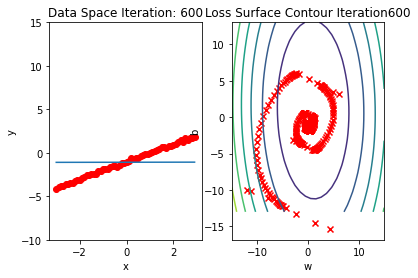

In [33]:
# Practice: Use SGD with trainloader to train model and store the total loss in LOSS

LOSS = []
w = torch.tensor(-12.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
df = Data()
trainLoader = DataLoader(dataset=df, batch_size=1)

def my_train_model(epochs):
    for epoch in range(epochs):
        y_hat = forward(X)
        loss=criterion(y_hat,Y)
        LOSS.append(loss.tolist())
        
        for x,y in trainLoader:
            y_hat_sample = forward(x)
            loss_sample = criterion(y_hat_sample, Y)
            
            get_surface_2.set_para_loss(w.data.tolist(), b.data.tolist(), loss_sample.tolist())
            
            loss_sample.backward()
            
            w.data=w.data - lr * w.grad.data
            b.data=b.data - lr * b.grad.data
            
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        get_surface_2.plot_ps()
my_train_model(10)
        

Double-click <b>here</b> for the solution.

<!-- 
def my_train_model(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        LOSS.append(criterion(Yhat, X))
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()
        get_surface.plot_ps()
my_train_model(10)
-->


Plot the total loss


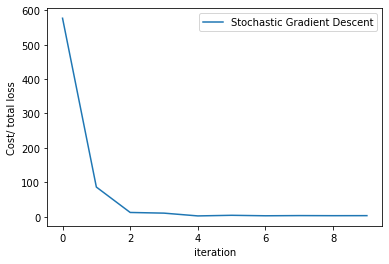

In [34]:
plt.plot(LOSS,label = "Stochastic Gradient Descent")
plt.xlabel('iteration')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

Double-click **here** for the solution.

<!-- 
plt.plot(LOSS,label = "Stochastic Gradient Descent")
plt.xlabel('iteration')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()
-->
